<a href="https://colab.research.google.com/github/Manas-P/forecasting_co2_emission_threshold/blob/main/Forecast_co2_threshold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
url='https://raw.githubusercontent.com/Manas-P/forecasting_co2_emission_threshold/main/emission_dataset.csv'
df=pd.read_csv(url)

In [4]:
df.head()

,Date,CO Amount (g/km)
0,2010-01,0.001
1,2010-02,0.026
2,2010-03,0.043
3,2010-04,0.068
4,2010-05,0.089


In [5]:
df.tail()

,Date,CO Amount (g/km)
127,2020-08,0.641
128,2020-09,0.636
129,2020-10,0.624
130,2020-11,0.612
131,2020-12,0.600


In [6]:
df['Date']=pd.to_datetime(df['Date']) #Converted Month into Datetime

In [7]:
df.head()

,Date,CO Amount (g/km)
0,2010-01-01,0.001
1,2010-02-01,0.026
2,2010-03-01,0.043
3,2010-04-01,0.068
4,2010-05-01,0.089


In [8]:
df.set_index('Date',inplace=True) #Set month column as index

In [9]:
df.head()

,CO Amount (g/km)
Date,
2010-01-01,0.001
2010-02-01,0.026
2010-03-01,0.043
2010-04-01,0.068
2010-05-01,0.089


In [10]:
df.describe()

,CO Amount (g/km)
count,132.000000
mean,0.347447
std,0.175182
min,0.001000
25%,0.198500
50%,0.356000
75%,0.492000
max,0.654000


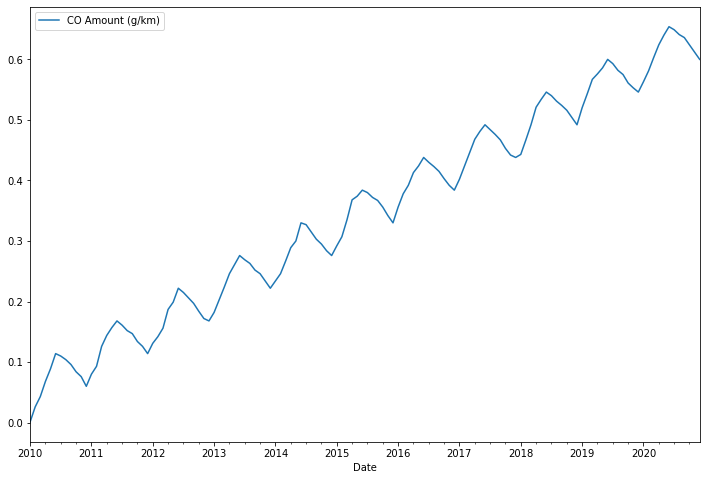

In [11]:
df.plot(figsize=(12,8))

In [13]:
### Testing For Stationarity

from statsmodels.tsa.stattools import adfuller

In [14]:
test_result=adfuller(df['CO Amount (g/km)'])

In [15]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(co):
    result=adfuller(co)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [16]:
adfuller_test(df['CO Amount (g/km)'])

ADF Test Statistic : -0.018282603020073354
p-value : 0.9569937580740829
#Lags Used : 12
Number of Observations Used : 119
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [17]:
#Differencing
df['CO First Difference'] = df['CO Amount (g/km)'] - df['CO Amount (g/km)'].shift(1)

In [18]:
df['CO Amount (g/km)'].shift(1)

Date
2010-01-01      NaN
2010-02-01    0.001
2010-03-01    0.026
2010-04-01    0.043
2010-05-01    0.068
              ...  
2020-08-01    0.649
2020-09-01    0.641
2020-10-01    0.636
2020-11-01    0.624
2020-12-01    0.612
Name: CO Amount (g/km), Length: 132, dtype: float64

In [19]:
df['Seasonal First Difference']=df['CO Amount (g/km)']-df['CO Amount (g/km)'].shift(12)

In [21]:
df.head()

,CO Amount (g/km),CO First Difference,Seasonal First Difference
Date,,,
2010-01-01,0.001,NaN,NaN
2010-02-01,0.026,0.025,NaN
2010-03-01,0.043,0.017,NaN
2010-04-01,0.068,0.025,NaN
2010-05-01,0.089,0.021,NaN


In [22]:
## Again test dickey fuller test
adfuller_test(df['Seasonal First Difference'].dropna())

ADF Test Statistic : -4.411344479190653
p-value : 0.00028340703441989907
#Lags Used : 13
Number of Observations Used : 106
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


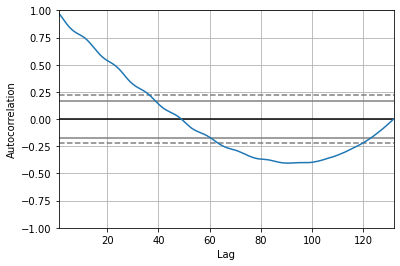

In [23]:
# Auto Regressive modal
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['CO Amount (g/km)'])
plt.show()

In [24]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


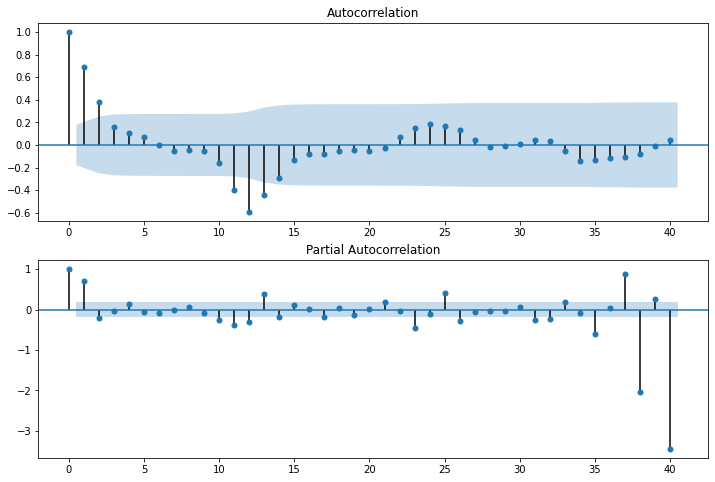

In [25]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Seasonal First Difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Seasonal First Difference'].iloc[13:],lags=40,ax=ax2)

In [26]:
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
# For non-seasonal data
model=ARIMA(df['CO Amount (g/km)'],order=(1,1,1))
model_fit=model.fit()

In [28]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:     D.CO Amount (g/km)   No. Observations:                  131
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 370.859
Method:                       css-mle   S.D. of innovations              0.014
Date:                Sun, 19 Dec 2021   AIC                           -733.719
Time:                        13:13:59   BIC                           -722.218
Sample:                    02-01-2010   HQIC                          -729.046
                         - 12-01-2020                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.0045      0.000     21.133      0.000       0.004       0.005
ar.L1.D.CO Amount (g/km)     0.8698      0.050     17.360      0.000       0.772       0.968
ma.L1.D.CO Amount (g/km)    -1.0000      0.020    -50.813      0.000      -1.039      -0.961
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1497           +0.0000j            1.1497            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

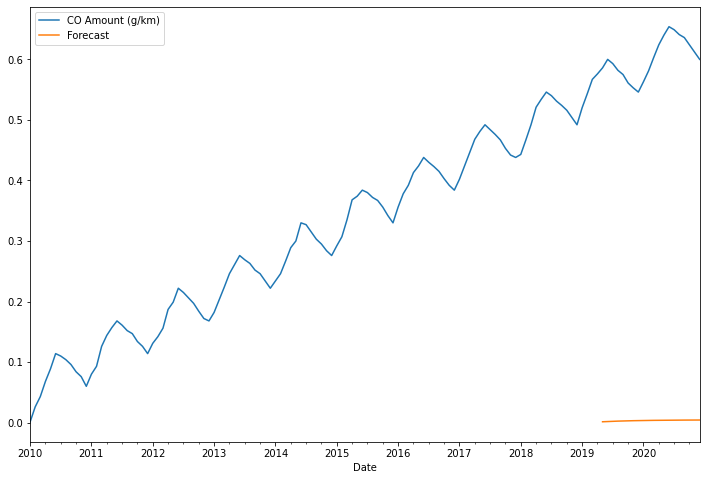

In [29]:
df['Forecast']=model_fit.predict(start=112,end=131,dynamic=True)
df[['CO Amount (g/km)','Forecast']].plot(figsize=(12,8))

In [ ]:
model=sm.tsa.statespace.SARIMAX(df['CO Amount (g/km)'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

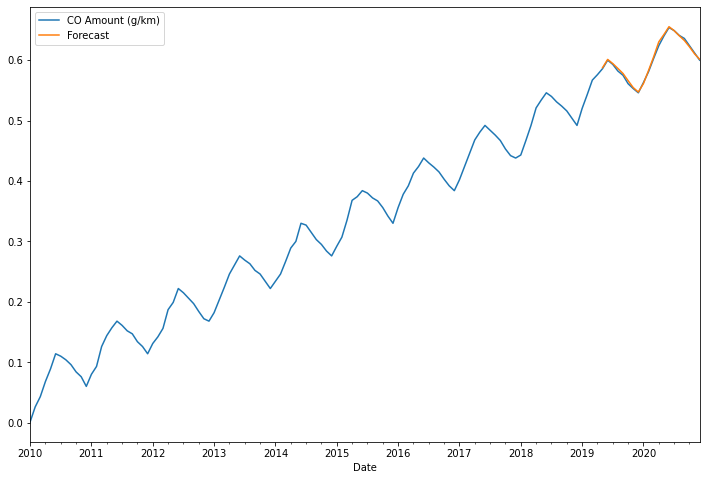

In [31]:
df['Forecast']=results.predict(start=112,end=131,dynamic=True)
df[['CO Amount (g/km)','Forecast']].plot(figsize=(12,8))

In [32]:
#To find future
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,96)] #Given upto 8 years

In [33]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns) #Future values

In [34]:
future_datest_df.tail()

,CO Amount (g/km),CO First Difference,Seasonal First Difference,Forecast
2028-07-01,NaN,NaN,NaN,NaN
2028-08-01,NaN,NaN,NaN,NaN
2028-09-01,NaN,NaN,NaN,NaN
2028-10-01,NaN,NaN,NaN,NaN
2028-11-01,NaN,NaN,NaN,NaN


In [35]:
future_df=pd.concat([df,future_datest_df]) #Concatenate current dataset to future dataset

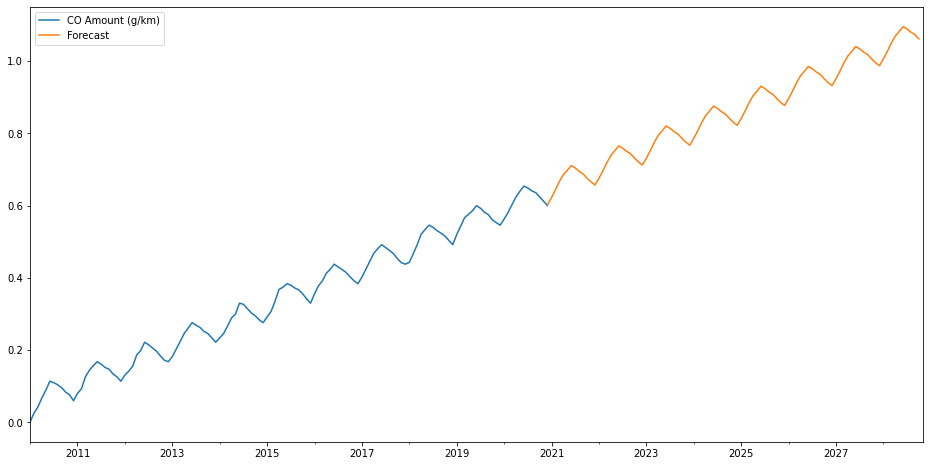

In [37]:
future_df['Forecast'] = results.predict(start = 131, end = 225, dynamic= True)   
future_df[['CO Amount (g/km)', 'Forecast']].plot(figsize=(16, 8)) 

In [41]:
#Predicting the year when the co2 emission will exceed the limit
df_new = future_df[future_df['Forecast'] >= 1].index[0]
print("Your vehicle will emit CO beyond the limit at the year: ",df_new)

Your vehicle will emit CO beyond the limit at the year:  2027-04-01 00:00:00
